
# Traditional Machine Learning Approach
**Competition:** MAP — Charting Student Math Misunderstandings

**Goal:** predict up to **3** `Category:Misconception` labels per row to maximize **MAP@3**.

**Approach:** concatenate problem text, student MC answer, and their explanation → TF‑IDF → linear classifier (SGD `log_loss`).  
We evaluate with **GroupKFold** split by `QuestionId` to reduce leakage, then train on full data and create **`submission.csv`**.

**Original Notebook:** https://www.kaggle.com/code/kyrcovarick/map-misconceptions-baseline

In [ ]:
import os, gc
import numpy as np
import pandas as pd

from sklearn.base import clone
from sklearn.model_selection import GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from IPython.display import display, Latex

np.random.seed(42)

# MAP@K metric (K=3 per competition)
def apk(actual, predicted, k=3):
    """Average precision at k for a single observation.
    `actual` is a single-element list [true_label] (competition has one truth per row).
    `predicted` is an ordered list of labels (top-k predictions).
    """
    if not actual:
        return 0.0
    if k < len(predicted):
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p == actual[0]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
            break  # only one relevant label per row
    return score

def mapk(actual_list, predicted_list, k=3):
    return np.mean([apk([a], p, k) for a, p in zip(actual_list, predicted_list)])

def topk_from_proba(class_labels, proba_row, k=3):
    idx = np.argsort(-proba_row)[:k]
    return [class_labels[i] for i in idx]

print("Libraries loaded.")

Libraries loaded.


## Load Data

In [2]:
# Detect Kaggle input path
KAGGLE_INPUT = "/kaggle/input/map-charting-student-math-misunderstandings"
LOCAL_INPUT = "../input/map-charting-student-math-misunderstandings"
HERE = os.getcwd()

if os.path.exists(KAGGLE_INPUT):
    DATA_DIR = KAGGLE_INPUT
elif os.path.exists(LOCAL_INPUT):
    DATA_DIR = LOCAL_INPUT
else:
    # Fallback to working directory (for local testing with provided CSVs)
    DATA_DIR = "data"

print("DATA_DIR =", DATA_DIR)

DATA_DIR = data


In [3]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

## Explore data

In [4]:
print(train_df.shape)
train_df.head(3)

(36696, 7)


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NaN
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NaN
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NaN


In [5]:
print(test_df.shape)
test_df.head(3)

(3, 5)


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si..."
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.


Note: There are only 3 rows in test_df - we can safely assume that all diversity is in train_df

### Questions and Answers

In [6]:
group_by_question_df = train_df[["QuestionId", "MC_Answer"]].groupby("QuestionId")["MC_Answer"].agg(set).reset_index()
group_by_question_df

,QuestionId,MC_Answer
0,31772,"{\( \frac{3}{9} \), \( \frac{1}{3} \), \( \fra..."
1,31774,"{\( \frac{1}{3} \), \( \frac{1}{12} \), \( \fr..."
2,31777,"{\( 60 \), \( 48 \), \( 72 \), \( 24 \)}"
3,31778,"{\( 9 \), \( 6 \), \( 4 \), \( 3 \)}"
4,32829,"{\( 4 \), \( 48 \), \( 12 \), \( 22 \)}"
5,32833,"{\( \frac{10}{15} \), \( 3 \frac{1}{3} \), \( ..."
6,32835,"{\( 6.079 \), \( 6 \), \( 6.0001 \), \( 6.2 \)}"
7,33471,"{\( 8 \), \( 9 \), \( 3 \), \( 15 \)}"
8,33472,"{\( \frac{11}{30} \), \( \frac{11}{15} \), \( ..."
9,33474,"{\( \frac{1}{3} \times \frac{2}{3} \), \( \fra..."


In [7]:
# Verify that all questions have exactly 4 possible answers
(group_by_question_df["MC_Answer"].apply(len) == 4).all()

True

In [8]:
# Mathematical expression are correctly displayed with Latex function only when wrapped in $ sign
def to_latex(text):
    return text.replace('\\(', '$').replace('\\)', '$')

In [9]:
for index, question_row in group_by_question_df.iterrows():
    question = train_df.loc[train_df.QuestionId == question_row.QuestionId].iloc[0].QuestionText
    clean_question = to_latex(question)
    display(Latex(f"Question {question_row.QuestionId}: {clean_question}"))

    # Letter to multi-choice answer relationship doesn't have to be correct
    answer_letters = "ABCD"
    answers = " ".join([f"({answer_letters[i]}) {to_latex(answer)}" for i, answer in enumerate(list(question_row.MC_Answer))])
    display(Latex(f"Answers: {answers}"))

    # Newline
    print()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Misconception classes

In [10]:
train_df["Misconception"] = train_df["Misconception"].fillna("NA")

misconception_classes = np.unique(train_df["Misconception"])
print(misconception_classes)
print(len(misconception_classes))

['Adding_across' 'Adding_terms' 'Additive' 'Base_rate' 'Certainty'
 'Definition' 'Denominator-only_change' 'Division' 'Duplication'
 'Firstterm' 'FlipChange' 'Ignores_zeroes' 'Incomplete'
 'Incorrect_equivalent_fraction_addition' 'Interior' 'Inverse_operation'
 'Inversion' 'Irrelevant' 'Longer_is_bigger' 'Mult' 'Multiplying_by_4'
 'NA' 'Not_variable' 'Positive' 'Scale' 'Shorter_is_bigger' 'Subtraction'
 'SwapDividend' 'Tacking' 'Unknowable' 'WNB' 'Whole_numbers_larger'
 'Wrong_Fraction' 'Wrong_Operation' 'Wrong_fraction' 'Wrong_term']
36


### Categories

Counts (sorted): [14802  9457  6542  5265   403   227]


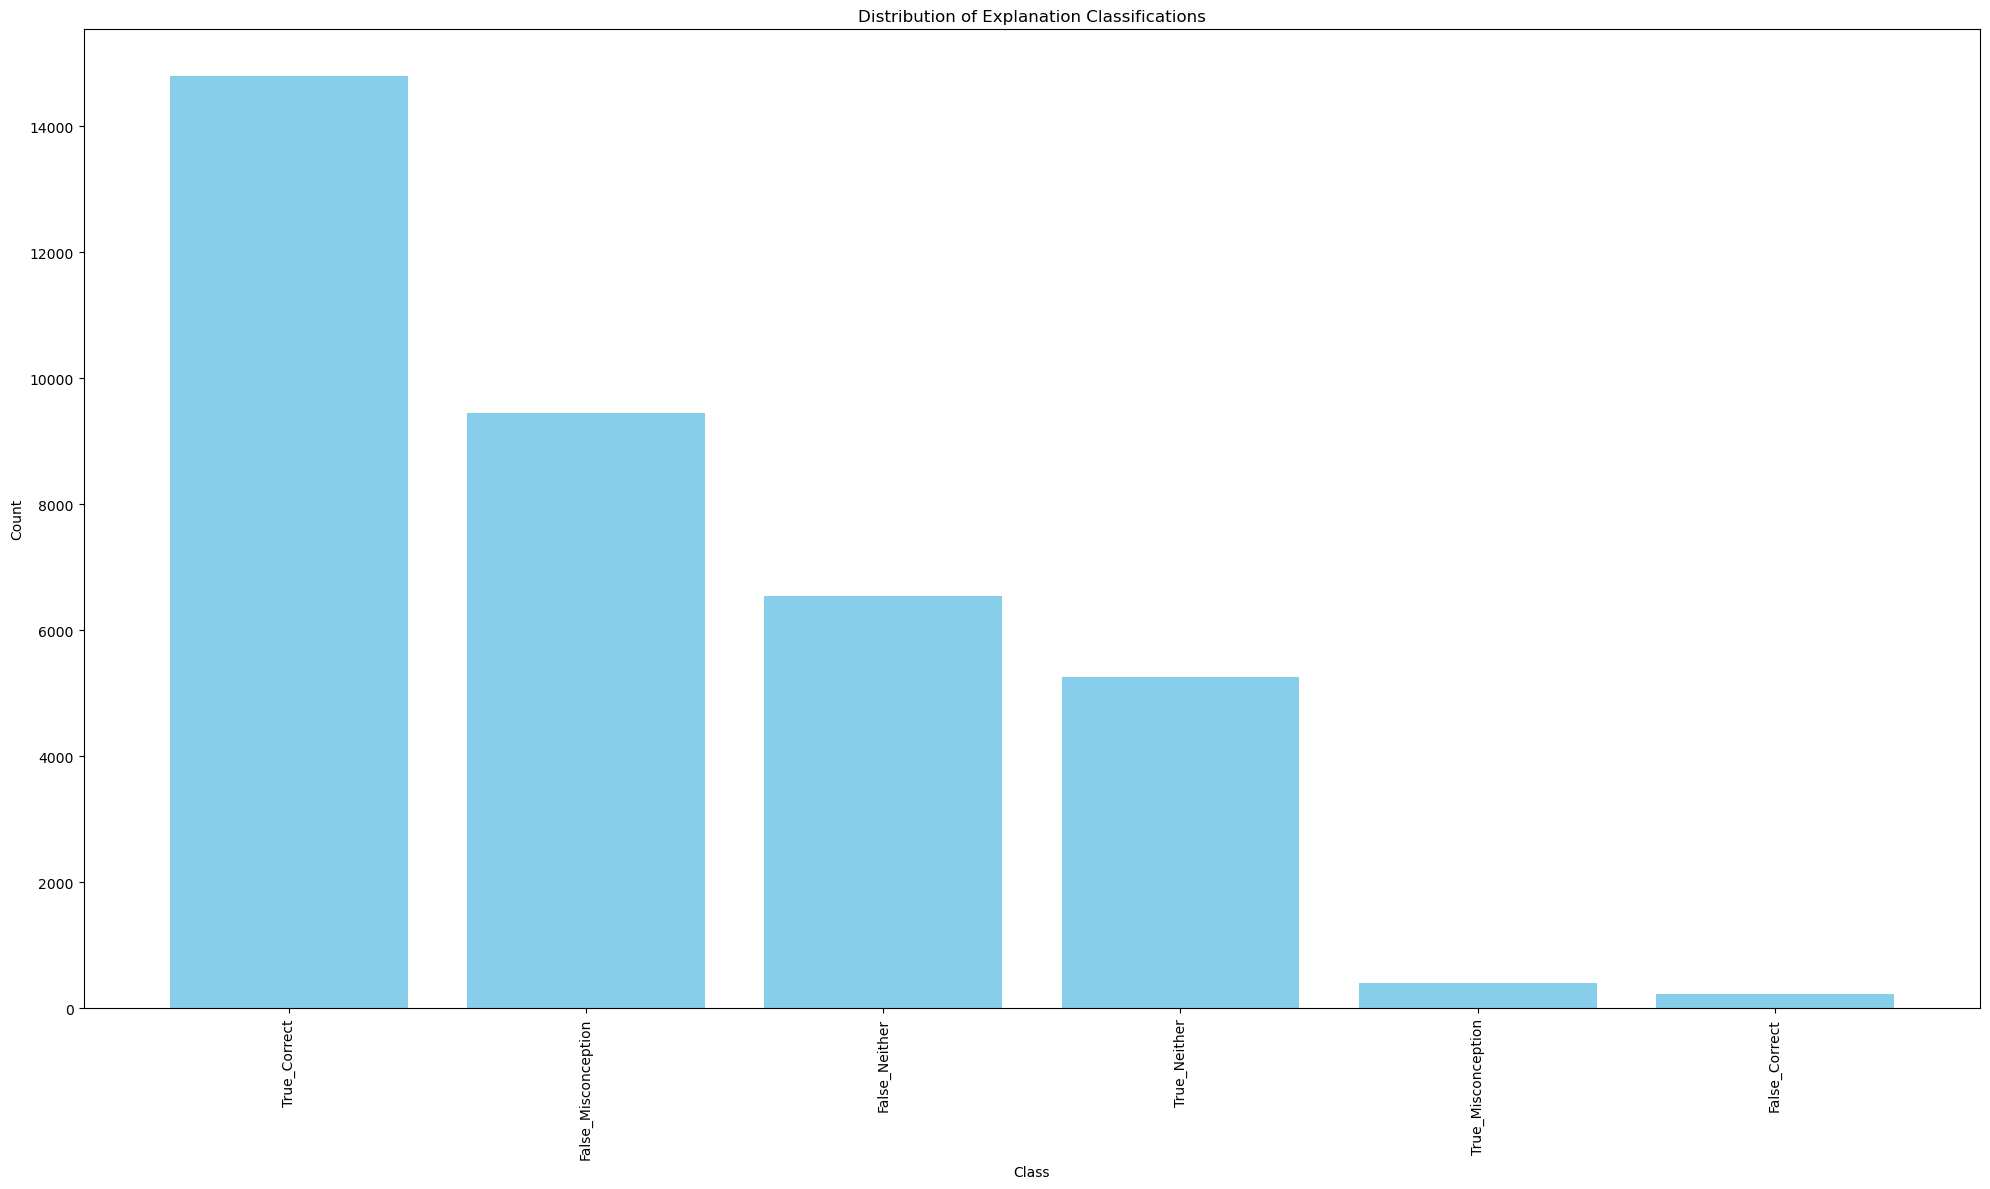

In [11]:
# Find the unique classes and their counts
classes, counts = np.unique(train_df["Category"], return_counts=True)

# Sort the counts and classes in descending order
sorted_indices = np.argsort(counts)[::-1]
sorted_classes = classes[sorted_indices]
sorted_counts = counts[sorted_indices]

# Create a bar chart for visualization
plt.figure(figsize=(20, 12))
plt.bar(sorted_classes.astype(str), sorted_counts, color="skyblue")
plt.title("Distribution of Explanation Classifications")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()

print("Counts (sorted):", sorted_counts)

## Prepare data

### Check `QuestionText` Column

In [12]:
# Verify that every QuestionId has only one QuestionText
is_one_to_one = train_df.groupby("QuestionId")["QuestionText"].nunique().eq(1).all()
is_one_to_one

True

### Clean `Category` Column

Based on explorations, there seems to be some correct `MC_Answer` values in the row with incorrect `Category` and vice versa.

In [13]:
# Let's split Category to Correct_Answer and Explanation_Eval to deal with them separately
train_df[["Correct_Answer", "Explanation_Eval"]] = train_df["Category"].str.split("_", expand=True)
# Let's remove for now - so we don't have to update it in two places
train_df = train_df.drop("Category", axis=1)
train_df.head(2)

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Misconception,Correct_Answer,Explanation_Eval
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,NA,True,Correct
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,NA,True,Correct


In [14]:
# Make sure all Misconceptions occur only when Explanation_Eval is Misconception
train_df[["Explanation_Eval", "Misconception"]].groupby("Explanation_Eval").agg(set)

,Misconception
Explanation_Eval,
Correct,{NA}
Misconception,"{Adding_terms, Wrong_Fraction, Additive, First..."
Neither,{NA}


Counts (sorted): [1454  929  704  620  566  558  497  418  414  353  336  329  307  299
  290  282  273  206  179  154  107   97   96   78   63   54   50   24
   23   23   23   21   18    9    6]


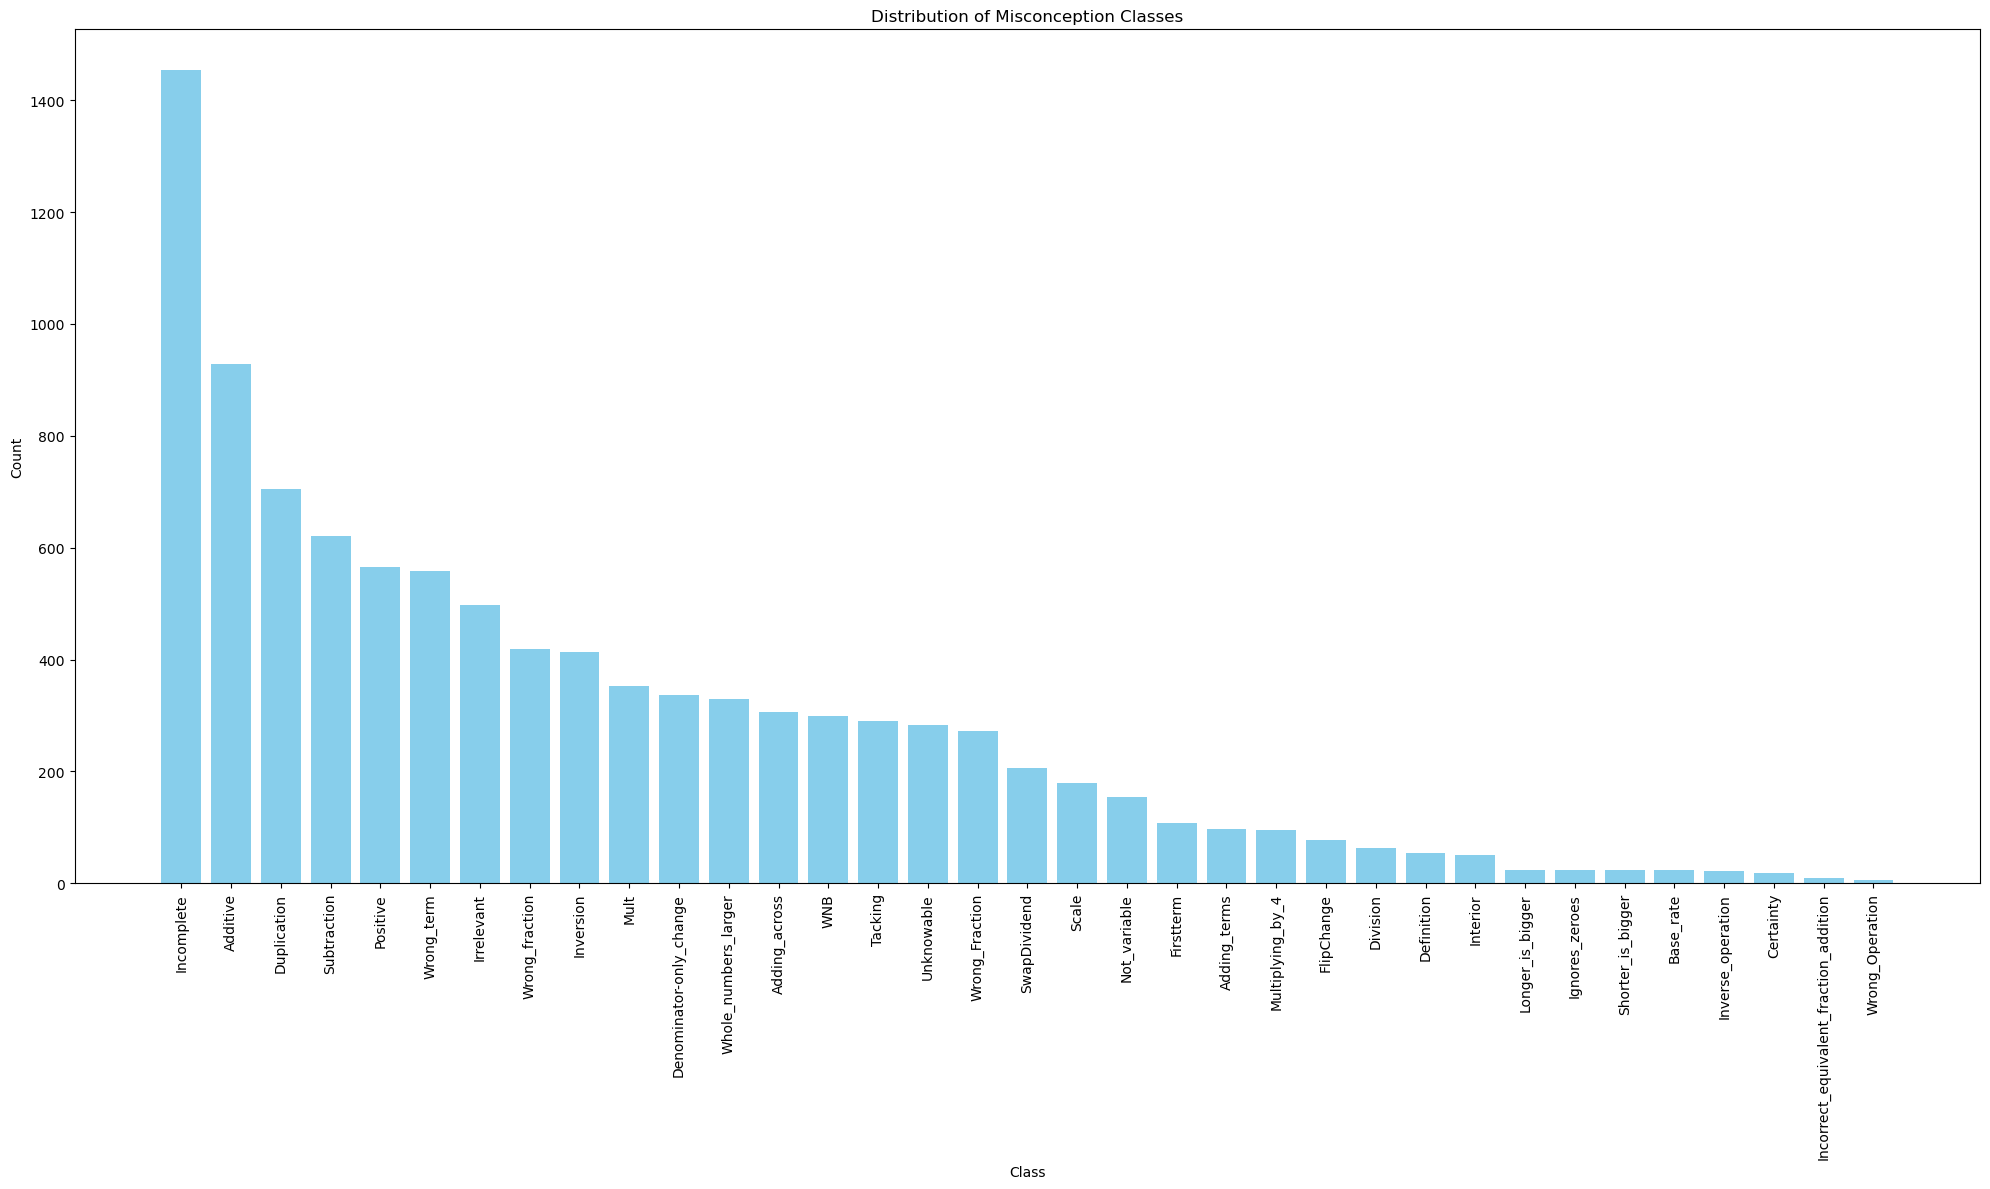

In [15]:
# Find the unique classes and their counts
classes, counts = np.unique(train_df["Misconception"][train_df["Misconception"] != "NA"], return_counts=True)

# Sort the counts and classes in descending order
sorted_indices = np.argsort(counts)[::-1]
sorted_classes = classes[sorted_indices]
sorted_counts = counts[sorted_indices]

# Create a bar chart for visualization
plt.figure(figsize=(20, 12))
plt.bar(sorted_classes.astype(str), sorted_counts, color="skyblue")
plt.title("Distribution of Misconception Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()

print("Counts (sorted):", sorted_counts)

#### Fix Correct Answers

`Correct_Answer` says `True` but `MC_Answer` is wrong.

In [16]:
# Group Questions and Correct Answers
def group_questions_with_correct_answers():
    return train_df[train_df["Correct_Answer"] == "True"][["QuestionId", "MC_Answer"]].groupby("QuestionId").agg(set).reset_index()

question_correct_answer = group_questions_with_correct_answers()
question_correct_answer

,QuestionId,MC_Answer
0,31772,{\( \frac{1}{3} \)}
1,31774,{\( \frac{1}{12} \)}
2,31777,{\( 72 \)}
3,31778,"{\( 9 \), \( 6 \)}"
4,32829,{\( 12 \)}
5,32833,{\( 3 \frac{1}{3} \)}
6,32835,{\( 6.2 \)}
7,33471,{\( 15 \)}
8,33472,{\( \frac{11}{15} \)}
9,33474,{\( \frac{1}{3} \times \frac{2}{3} \)}


In [17]:
# Check that there is exactly one correct answer
question_correct_answer[question_correct_answer["MC_Answer"].apply(len) != 1]

,QuestionId,MC_Answer
3,31778,"{\( 9 \), \( 6 \)}"


In [18]:
# Based on the question, we know that correct answer is `6`
for row in train_df.loc[
    (train_df.QuestionId == 31778)
    & (train_df.MC_Answer == "\\( 9 \\)")
    & (train_df.Correct_Answer == "True")
][["StudentExplanation", "Explanation_Eval"]].itertuples():
    explanation = row.StudentExplanation
    misconception = row.Explanation_Eval
    print(explanation, misconception)

Because 10 is 2 / 3 of 15, and 2 is 6. Neither
I divided 9/15 by 3, then got 3/5 and timsed it by 2 and got 6/10. Correct
I think it's C because 6/10 is the same as 9/15. Correct
Il believe that is the ansewer because I calculatted iti. Neither
It is six because they are both equal to 3over5. Correct
To get a denominator of 10, we need to divide by 3 and multiply by 2. Then, 9/15=3/5=6/10, so A = 6. Correct
You have to change the denominator to 150 then you will get the answer. Neither
i think this is because 9/15=18/30 and 6/10 =18-30. Correct
if you simplify it to 3/5 then you get 9/15. Neither
since 9 - 3 = 6h are so i't must be these ohne! Neither
so the common denominator is 30 and the product of 15x2=30 so 9x2, which is a multiple of 9, is 18 and 10x3 =30, so ax3, which we know is 18, is 18. therefore, a=6. Correct
this is because the top numbers go up in threes, and the bottom number go down in fives. Misconception


In [19]:
# Misconception classification seems to be fine
# Let's only change Correct_Answer to False
train_df.loc[
    (train_df.QuestionId == 31778)
    & (train_df.MC_Answer == "\\( 9 \\)")
    & (train_df.Correct_Answer == "True"),
    "Correct_Answer",
] = "False"

# Let's verify we didn't break anything
train_df.head(2)

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Misconception,Correct_Answer,Explanation_Eval
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,NA,True,Correct
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,NA,True,Correct


In [20]:
# Verify that problem is fixed
# Refresh dataframe
question_correct_answer = group_questions_with_correct_answers()
question_correct_answer[question_correct_answer["MC_Answer"].apply(len) != 1]

,QuestionId,MC_Answer


#### Fix Incorrect Answers

`Correct_Answer` says `False` but `MC_Answer` is correct.

In [21]:
# Group questions with wrong answers
def group_questions_with_incorrect_answers():
    return train_df[train_df["Correct_Answer"] == "False"][["QuestionId", "MC_Answer"]].groupby("QuestionId").agg(set).reset_index()

question_wrong_answer = group_questions_with_incorrect_answers()
question_wrong_answer

,QuestionId,MC_Answer
0,31772,"{\( \frac{3}{9} \), \( \frac{3}{6} \), \( \fra..."
1,31774,"{\( \frac{1}{3} \), \( \frac{6}{2} \), \( 3 \)}"
2,31777,"{\( 60 \), \( 48 \), \( 24 \)}"
3,31778,"{\( 9 \), \( 6 \), \( 4 \), \( 3 \)}"
4,32829,"{\( 48 \), \( 4 \), \( 22 \)}"
5,32833,"{\( \frac{10}{15} \), \( \frac{2}{15} \), \( 5..."
6,32835,"{\( 6.079 \), \( 6 \), \( 6.0001 \)}"
7,33471,"{\( 8 \), \( 9 \), \( 3 \)}"
8,33472,"{\( \frac{11}{30} \), \( \frac{3}{15} \), \( \..."
9,33474,"{\( \frac{2}{3} \div \frac{1}{3} \), \( \frac{..."


In [22]:
# Check if correct answer is not among the wrong answers
# That would mean that MC_Answer is correct for QuestionId, but Category says otherwise
for questionId in question_wrong_answer.QuestionId:
    correct_answers = question_correct_answer[question_correct_answer.QuestionId == questionId].MC_Answer.iloc[0]
    wrong_answers = question_wrong_answer[question_wrong_answer.QuestionId == questionId].MC_Answer.iloc[0]

    if list(correct_answers)[0] in wrong_answers:
        print(questionId, wrong_answers) 

31778 {'\\( 9 \\)', '\\( 6 \\)', '\\( 4 \\)', '\\( 3 \\)'}


In [23]:
# Correct answer is `6`
# Let's check explanations first to see whether student mistakenly chose 6, or there is error in category
for row in train_df.loc[
    (train_df.QuestionId == 31778)
    & (train_df.MC_Answer == "\\( 6 \\)")
    & (train_df.Correct_Answer == "False")
][["StudentExplanation", "Explanation_Eval"]].itertuples():
    explanation = row.StudentExplanation
    misconception = row.Explanation_Eval
    print(explanation, misconception)

Because on the second fraction it has a 9. Neither
Because when I work is out with rthe bar methood che awser comed up with 9. Neither
becose thirty tope number is a nine. Neither
i worked it out on my white board Neither
m'y dad andave i bothe guessed that we nedded to use la common denominator, but i wasn't ' t sur how that woulld work whith improper fractions. Neither
tha answear is d becase yoy can ' t simplify 9. Neither


In [24]:
# It seems that most of them wanted to choose 9 - so let's replace 6 with 9 as answer.
train_df.loc[
    (train_df.QuestionId == 31778)
    & (train_df.MC_Answer == "\\( 6 \\)")
    & (train_df.Correct_Answer == "False"),
    "MC_Answer",
] = "\\( 9 \\)"

# Check that we didn't break anything
train_df.head(2)

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Misconception,Correct_Answer,Explanation_Eval
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,NA,True,Correct
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,NA,True,Correct


In [25]:
# Verify fix
# Refresh dataframe
question_wrong_answer = group_questions_with_incorrect_answers()
for questionId in question_wrong_answer.QuestionId:
    correct_answers = question_correct_answer[question_correct_answer.QuestionId == questionId].MC_Answer.iloc[0]
    wrong_answers = question_wrong_answer[question_wrong_answer.QuestionId == questionId].MC_Answer.iloc[0]

    if list(correct_answers)[0] in wrong_answers:
        print(questionId, wrong_answers) 

### Prepare Input and Target

In [26]:
# Let's bring back category
train_df["Category"] = train_df.Correct_Answer + "_" + train_df.Explanation_Eval
train_df.head(2)

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Misconception,Correct_Answer,Explanation_Eval,Category
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,NA,True,Correct,True_Correct
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,NA,True,Correct,True_Correct


In [27]:
# Based on the discussion here: https://www.kaggle.com/competitions/map-charting-student-math-misunderstandings/discussion/589400.
# It seems public data have all the questions (secret test set doesn't include new questions).
# So we can safely use correct answer flag in input data

def add_correct_answer(dataframe):
    dataframe["Correct_Answer"] = [
        list(question_correct_answer[question_correct_answer["QuestionId"] == answer["QuestionId"]]["MC_Answer"].iloc[0])[0] == answer["MC_Answer"]
        for index, answer in dataframe[["QuestionId", "MC_Answer"]].iterrows()
    ]
    return dataframe

test_df = add_correct_answer(test_df)
test_df.head(3)

,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Correct_Answer
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",True
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,False
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,True


In [28]:
# Build single target label "Category:Misconception"
train_df["target"] = (
    train_df["Category"].astype(str) + ":" + train_df["Misconception"].astype(str)
)

# Text features: concatenate question, MC answer, Is correct answer, and explanation
def combine_text(df):
    return (
        df["QuestionText"].fillna("")
        + " [MC] "
        + df["MC_Answer"].fillna("")
        + " [CORRECT] "
        + df["Correct_Answer"].astype(str)
        + " [EXPL] "
        + df["StudentExplanation"].fillna("")
    )


X_text = combine_text(train_df)
X_test_text = combine_text(test_df)

y = train_df["target"].values
groups = train_df["QuestionId"].values

print("Unique classes:", len(np.unique(y)))
print("Example label:", y[0])
print("Text example:", X_text.iloc[0][:300])

Unique classes: 65
Example label: True_Correct:NA
Text example: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.] [MC] \( \frac{1}{3} \) [CORRECT] True [EXPL] 0ne third is equal to tree nineth


Counts (sorted): [14796  6547  5260  1446   891   698   618   564   550   412   410   409
   345   332   328   306   291   282   273   233   198   179   162   153
   128    97    96    93    87    74    58    51    50    38    23    23
    22    21    18    17    11     8     8     8     8     8     7     6
     6     6     6     5     5     4     4     3     3     2     2     2
     1     1     1     1     1]


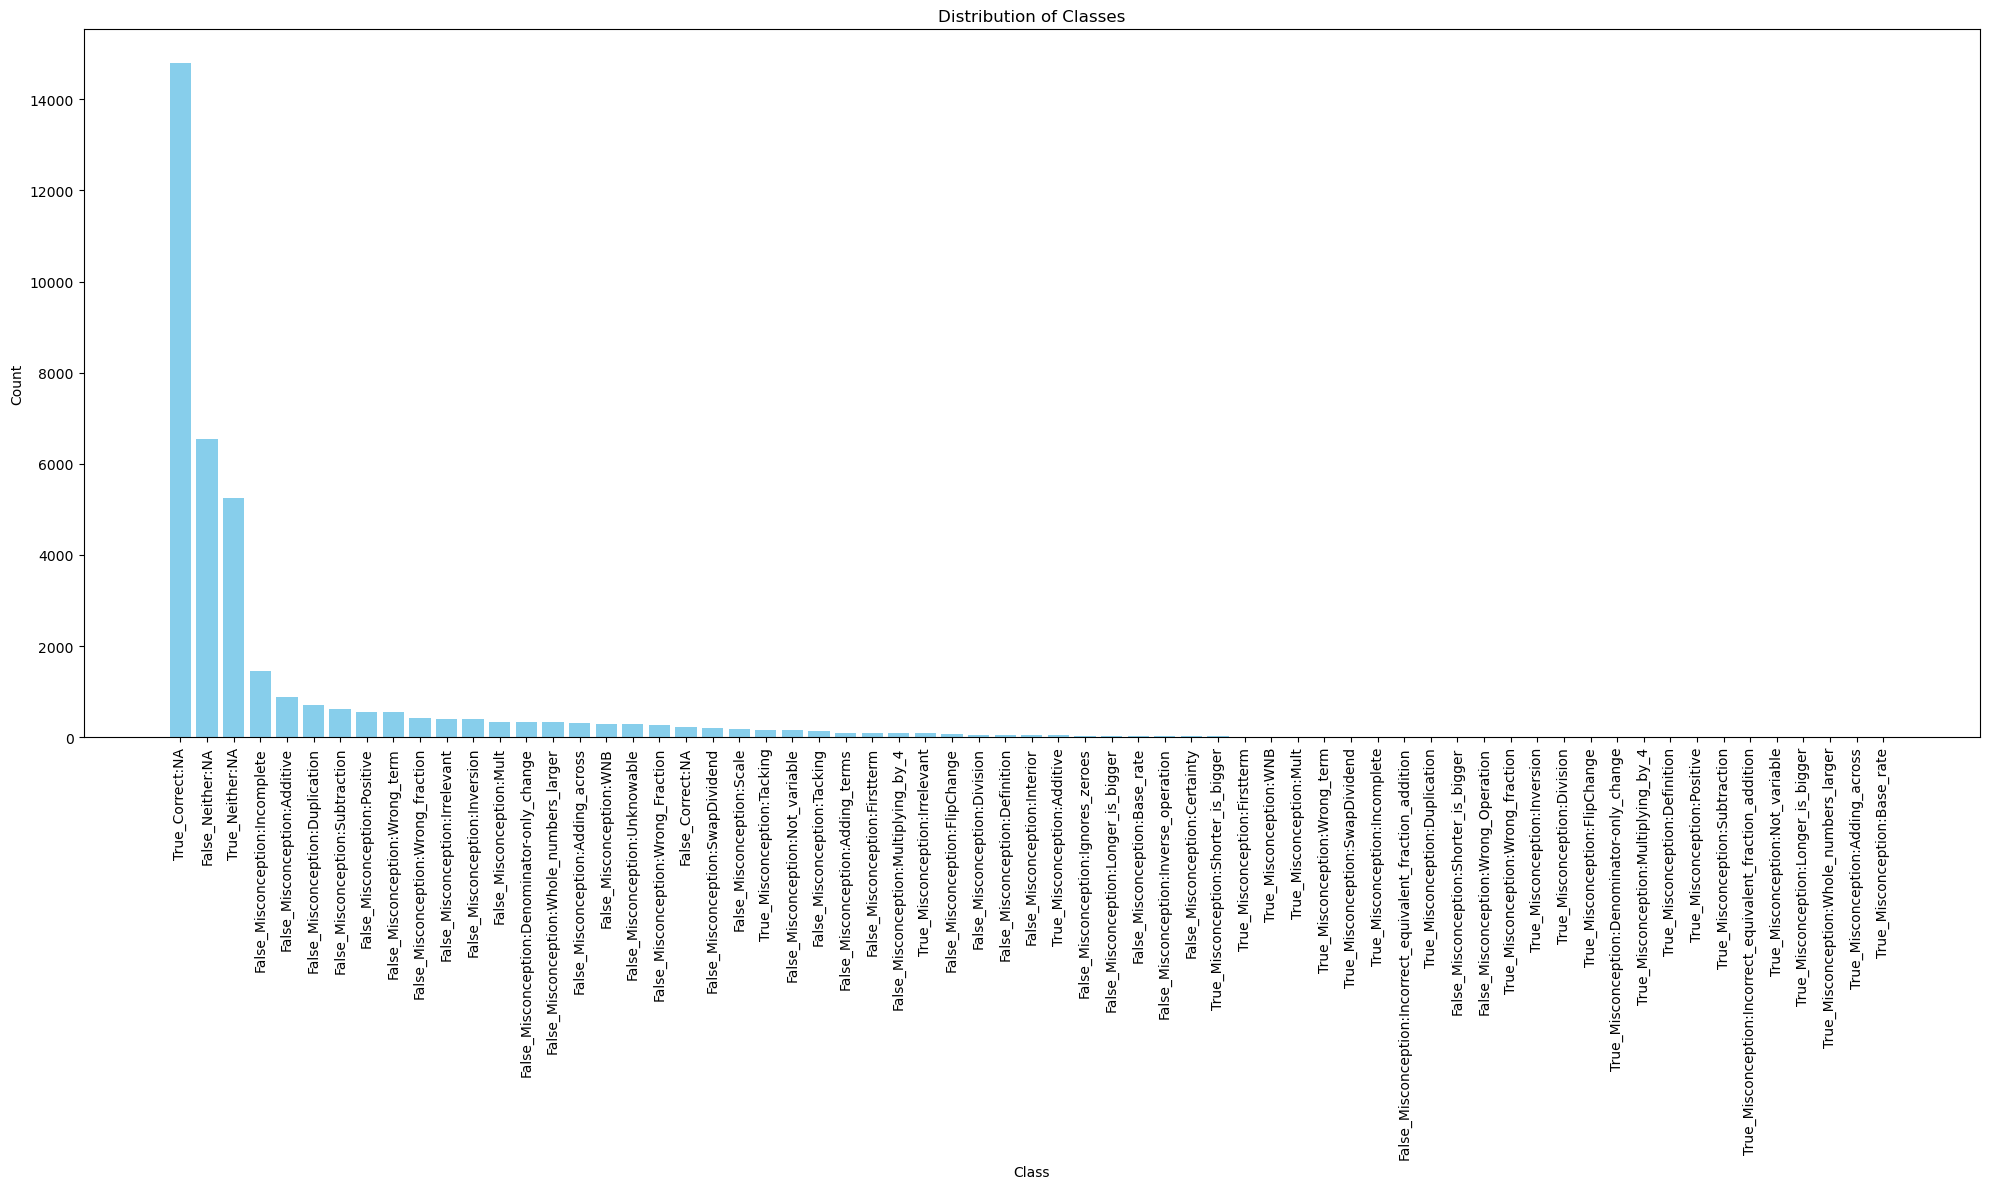

In [29]:
# Find the unique classes and their counts
classes, counts = np.unique(y, return_counts=True)

# Sort the counts and classes in descending order
sorted_indices = np.argsort(counts)[::-1]
sorted_classes = classes[sorted_indices]
sorted_counts = counts[sorted_indices]

# Create a bar chart for visualization
plt.figure(figsize=(20, 12))
plt.bar(sorted_classes.astype(str), sorted_counts, color="skyblue")
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()

print("Counts (sorted):", sorted_counts)

## Model Pipeline

In [30]:
# A simple but strong baseline:
# - Char-level TF-IDF (3-5 grams)
# - Word-level TF-IDF (1-2 grams)
# - SGDClassifier with log_loss to get predict_proba for many classes efficiently

# Word-level pipeline
word_pipeline = Pipeline(
    [
        (
            "vectorizer",
            TfidfVectorizer(
                analyzer="word",
                lowercase=True,
                strip_accents="unicode",
                ngram_range=(1, 2),
                max_features=250_000,
                min_df=2,
            ),
        ),
    ]
)

# Character-level pipeline
char_pipeline = Pipeline(
    [
        (
            "vectorizer",
            TfidfVectorizer(
                lowercase=True,
                strip_accents="unicode",
                analyzer="char_wb",
                ngram_range=(3, 5),
                max_features=250_000,
                min_df=2,
            ),
        ),
    ]
)

# Combine both pipelines using FeatureUnion
combined_features = FeatureUnion(
    [("word_features", word_pipeline), ("char_features", char_pipeline)]
)

pipeline = Pipeline(
    [
        ("features", combined_features),
        (
            "clf",
            SGDClassifier(
                loss="log_loss",
                penalty="l2",
                alpha=1e-5,
                max_iter=10_000,
                tol=1e-4,
                random_state=42,
                class_weight="balanced",
            ),
        ),
    ]
)

pipeline

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('word_features',
                                                 Pipeline(steps=[('vectorizer',
                                                                  TfidfVectorizer(max_features=250000,
                                                                                  min_df=2,
                                                                                  ngram_range=(1,
                                                                                               2),
                                                                                  strip_accents='unicode'))])),
                                                ('char_features',
                                                 Pipeline(steps=[('vectorizer',
                                                                  TfidfVectorizer(analyzer='char_wb',
                                                                                  max_features=250000,
                                                                                  min_df=2,
                                                                                  ngram_range=(3,
                                                                                               5),
                                                                                  strip_accents='unicode'))]))])),
                ('clf',
                 SGDClassifier(alpha=1e-05, class_weight='balanced',
                               loss='log_loss', max_iter=10000, random_state=42,
                               tol=0.0001))])

## Evaluation

### Cross-Validation

In [31]:
N_FOLDS = 5
gkf = GroupKFold(n_splits=N_FOLDS)

oof_true = []
oof_pred_single = []
oof_pred_topk = []

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_text, y, groups), 1):
    X_tr, X_va = X_text.iloc[tr_idx], X_text.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    model = clone(pipeline)
    model.fit(X_tr, y_tr)

    # Predict probabilities for validation
    proba = model.predict_proba(X_va)
    classes = model.named_steps['clf'].classes_

    # Single predictions (highest probability)
    pred_single = model.predict(X_va)

    # Top-k predictions for MAP@3
    pred_topk = [topk_from_proba(classes, row, k=3) for row in proba]

    oof_true.extend(list(y_va))
    oof_pred_single.extend(pred_single)
    oof_pred_topk.extend(pred_topk)

    fold_map3 = mapk(list(y_va), pred_topk, k=3)
    print(f"Fold {fold} MAP@3: {fold_map3:.5f}")
    gc.collect()

cv_map3 = mapk(oof_true, oof_pred_topk, k=3)
print(f"\nCV MAP@3 (mean over out-of-fold): {cv_map3:.5f}")

Fold 1 MAP@3: 0.64500
Fold 2 MAP@3: 0.59495
Fold 3 MAP@3: 0.62940
Fold 4 MAP@3: 0.59977
Fold 5 MAP@3: 0.66644

CV MAP@3 (mean over out-of-fold): 0.62783


### Top-k confusion analysis

In [32]:
def analyze_topk_predictions(y_true, y_pred_topk, k=3):
    """Analyze how often true labels appear in top-k predictions"""
    correct_at_k = []
    
    for true_label, pred_topk in zip(y_true, y_pred_topk):
        if true_label in pred_topk:
            position = pred_topk.index(true_label) + 1  # 1-indexed
            correct_at_k.append(position)
        else:
            correct_at_k.append(0)  # Not in top-k
    
    print(f"\n=== Top-{k} Prediction Analysis ===")
    for pos in range(1, k+1):
        count = sum(1 for x in correct_at_k if x == pos)
        pct = count / len(correct_at_k) * 100
        print(f"Correct at position {pos}: {count} ({pct:.1f}%)")
    
    not_in_topk = sum(1 for x in correct_at_k if x == 0)
    pct_not_in_topk = not_in_topk / len(correct_at_k) * 100
    print(f"Not in top-{k}: {not_in_topk} ({pct_not_in_topk:.1f}%)")

analyze_topk_predictions(oof_true, oof_pred_topk, k=3)


=== Top-3 Prediction Analysis ===
Correct at position 1: 19920 (54.3%)
Correct at position 2: 5492 (15.0%)
Correct at position 3: 1118 (3.0%)
Not in top-3: 10166 (27.7%)


### Analyze misclassifications in detail

In [33]:
def analyze_misclassifications(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # Percentage confusion matrix
    cm_pct = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create summary table for each class
    summary_data = []

    for i, true_class in enumerate(classes):
        total_samples = cm[i].sum()
        correct_predictions = cm[i, i]
        misclassifications = total_samples - correct_predictions

        if total_samples > 0:
            misclassification_rate = (misclassifications / total_samples) * 100
            accuracy = (correct_predictions / total_samples) * 100

            # Find most frequent wrong prediction
            wrong_predictions = [
                (classes[j], cm[i, j], cm_pct[i, j])
                for j in range(len(classes))
                if i != j and cm[i, j] > 0
            ]

            if wrong_predictions:
                # Sort by count (not percentage) to find most frequent error
                most_frequent_error = max(wrong_predictions, key=lambda x: x[1])
                most_frequent_error_class = most_frequent_error[0]
                most_frequent_error_count = most_frequent_error[1]
                most_frequent_error_pct = most_frequent_error[2]
            else:
                most_frequent_error_class = "None"
                most_frequent_error_count = 0
                most_frequent_error_pct = 0.0

            summary_data.append(
                {
                    "True_Class": true_class,
                    "Total_Samples": total_samples,
                    "Correct": correct_predictions,
                    "Accuracy_%": accuracy,
                    "Misclassified": misclassifications,
                    "Misclassification_%": misclassification_rate,
                    "Most_Frequent_Error": most_frequent_error_class,
                    "Error_Count": most_frequent_error_count,
                    "Error_%_of_Class": most_frequent_error_pct,
                }
            )

    # Create summary DataFrame
    summary_df = pd.DataFrame(summary_data)

    # Sort by misclassification rate (worst performing classes first)
    summary_df = summary_df.sort_values("Misclassified", ascending=False)

    print("=== Class-by-Class Misclassification Analysis ===")
    print("(Sorted by misclassification - worst first)")
    print()
    print(summary_df.to_string(index=False, float_format="%.1f"))

all_classes = sorted(set(oof_true))
analyze_misclassifications(oof_true, oof_pred_single, all_classes)

=== Class-by-Class Misclassification Analysis ===
(Sorted by misclassification - worst first)

                                                True_Class  Total_Samples  Correct  Accuracy_%  Misclassified  Misclassification_%                Most_Frequent_Error  Error_Count  Error_%_of_Class
                                           True_Correct:NA          14796    10963        74.1           3833                 25.9                    True_Neither:NA         3268              22.1
                                           True_Neither:NA           5260     3029        57.6           2231                 42.4                    True_Correct:NA         2083              39.6
                            False_Misconception:Incomplete           1446        0         0.0           1446                100.0                   False_Neither:NA         1417              98.0
                              False_Misconception:Additive            891        0         0.0            891        

## Full Dataset Training

In [34]:
final_model = pipeline
final_model.fit(X_text, y)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('word_features',
                                                 Pipeline(steps=[('vectorizer',
                                                                  TfidfVectorizer(max_features=250000,
                                                                                  min_df=2,
                                                                                  ngram_range=(1,
                                                                                               2),
                                                                                  strip_accents='unicode'))])),
                                                ('char_features',
                                                 Pipeline(steps=[('vectorizer',
                                                                  TfidfVectorizer(analyzer='char_wb',
                                                                                  max_features=250000,
                                                                                  min_df=2,
                                                                                  ngram_range=(3,
                                                                                               5),
                                                                                  strip_accents='unicode'))]))])),
                ('clf',
                 SGDClassifier(alpha=1e-05, class_weight='balanced',
                               loss='log_loss', max_iter=10000, random_state=42,
                               tol=0.0001))])

## Test prediction and Kaggle Submission

In [35]:
test_proba = final_model.predict_proba(X_test_text)
classes = final_model.named_steps['clf'].classes_

top3 = [topk_from_proba(classes, row, k=3) for row in test_proba]

# Build submission
sub = pd.DataFrame({
    'row_id': test_df.index + 36696,  # Kaggle's sample_submission starts at this ID; we re-index safely
    'Category:Misconception': [' '.join(t) for t in top3]
})
sub.head()

,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA False_Neither:NA
1,36697,False_Misconception:WNB False_Misconception:In...
2,36698,True_Neither:NA True_Correct:NA False_Misconce...


In [36]:
# Use the provided sample_submission to ensure exact row_id ordering
sample_path = os.path.join(DATA_DIR, 'sample_submission.csv')
if os.path.exists(sample_path):
    sample = pd.read_csv(sample_path)
    if 'row_id' in sample.columns:
        sub = sample[['row_id']].merge(sub, on='row_id', how='left')
        # If any rows didn't merge (shouldn't happen), fill with a safe default
        default_label = 'True_Correct:NA'
        sub['Category:Misconception'] = sub['Category:Misconception'].fillna(default_label)
        print('Aligned with sample_submission.')
else:
    print('sample_submission.csv not found; using generated row_id sequence.')

sub.head(3)

Aligned with sample_submission.


,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA False_Neither:NA
1,36697,False_Misconception:WNB False_Misconception:In...
2,36698,True_Neither:NA True_Correct:NA False_Misconce...


In [37]:

SUB_PATH = 'submission.csv'
sub.to_csv(SUB_PATH, index=False)
print('Saved:', os.path.abspath(SUB_PATH))
sub.head()

Saved: /home/martin/Workspace/map-charting-student-math-misunderstandings/submission.csv


,row_id,Category:Misconception
0,36696,True_Correct:NA True_Neither:NA False_Neither:NA
1,36697,False_Misconception:WNB False_Misconception:In...
2,36698,True_Neither:NA True_Correct:NA False_Misconce...



## Notes & Next Steps
- Performance of this TF-IDF + Linear pipeline is disastrous when predicting Misconception categories,
  - Since Misconception categories are long tail and non-Misconception samples outweigh Misconception ones heavily, I even tried training and predicting with only Misconception samples, but it didn't help,
  - Based on Kaggle's discussions and notebooks, it seems that the only way is to use different model (XGBoost) and custom features (e.g. length of explanation),

### Original notes

- This is a **clean baseline**; strong gains often come from:
  - [x] Adding **character-level TF‑IDF** features (e.g., char 3–5 grams) and stacking with word TF‑IDF.
  - [x] Using **class-weighting** to handle long-tail misconception labels.
  - [ ] Ensembling multiple linear models or adding **lightweight neural** encoders (e.g., MiniLM) with pooling.
  - [ ] Normalizing math expressions / symbols; including `QuestionId`‑aware features.

- Keep runtime low and avoid leakage (we grouped by `QuestionId` for CV).
- Submit this notebook as **GPU/CPU (no internet)**. The output `submission.csv` is in the working directory.